# Temporal Modulation for Tabular Data

**Paper:** Feature-aware Modulation for Learning from Temporal Tabular Data (NeurIPS 2025)

**Authors:** Hao-Run Cai, Han-Jia Ye

This tutorial explains how temporal modulation works to handle **concept drift** in tabular data.

## The Problem: Concept Drift

In real-world tabular data, the relationship between features and targets often changes over time:

- **Financial data:** Market dynamics shift
- **Healthcare:** Treatment protocols evolve
- **E-commerce:** User preferences change seasonally

This is called **concept drift** — the same features can predict different outcomes at different times.

```
Time T1: income → loan_default (strong relationship)
Time T2: income → loan_default (weak relationship, employment_status matters more)
```

Standard models assume a fixed relationship, causing performance degradation over time.

## The Solution: FiLM (Feature-wise Linear Modulation)

The key idea is to **condition** the network's behavior on temporal context.

FiLM modulates features using learned scale (γ) and shift (β) parameters:

$$\text{FiLM}(x, t) = \gamma(t) \odot x + \beta(t)$$

Where:
- $x$ = input features
- $t$ = temporal encoding
- $\gamma(t)$ = time-dependent scale (learned)
- $\beta(t)$ = time-dependent shift (learned)
- $\odot$ = element-wise multiplication

This allows the model to adapt its feature processing based on **when** the data comes from.

In [2]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Component 1: Temporal Encoder

First, we need to encode the time information into a vector representation.

The temporal encoder uses **sinusoidal positional encoding** (like in Transformers) followed by an MLP:

1. **Sinusoidal Encoding:** Captures periodic patterns at different frequencies
2. **MLP:** Learns complex temporal patterns from the sinusoidal base

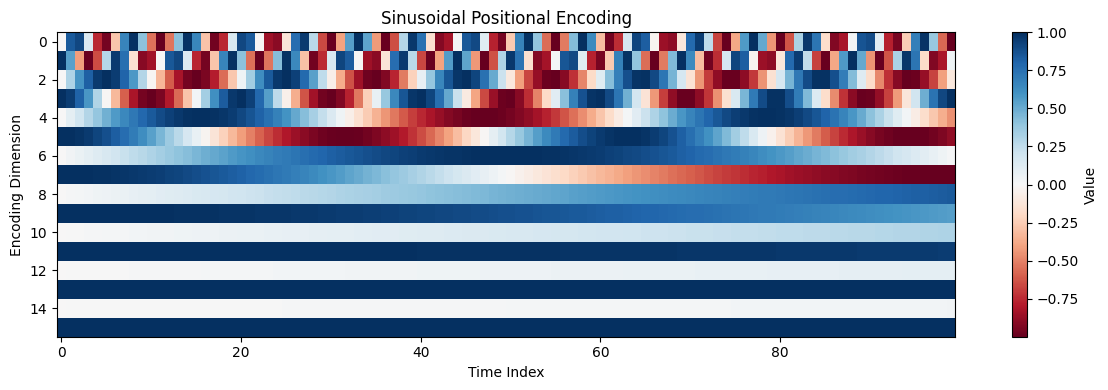

Encoding shape: torch.Size([100, 16])
Time 0 encoding (first 4 dims): [0. 1. 0. 1.]
Time 50 encoding (first 4 dims): [-0.26237485  0.96496606 -0.10324046 -0.99465644]


In [3]:
import math

class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for time indices."""
    
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        
        # Create encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Different frequencies for each dimension
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        
        pe[:, 0::2] = torch.sin(position * div_term)  # Even dimensions
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd dimensions
        
        self.register_buffer("pe", pe)
    
    def forward(self, time_idx: torch.Tensor) -> torch.Tensor:
        return self.pe[time_idx]

# Visualize the sinusoidal encoding
pe = PositionalEncoding(d_model=16, max_len=100)
time_indices = torch.arange(100)
encodings = pe(time_indices)

plt.figure(figsize=(12, 4))
plt.imshow(encodings.T.numpy(), aspect='auto', cmap='RdBu')
plt.xlabel('Time Index')
plt.ylabel('Encoding Dimension')
plt.title('Sinusoidal Positional Encoding')
plt.colorbar(label='Value')
plt.tight_layout()
plt.show()

print(f"Encoding shape: {encodings.shape}")
print(f"Time 0 encoding (first 4 dims): {encodings[0, :4].numpy()}")
print(f"Time 50 encoding (first 4 dims): {encodings[50, :4].numpy()}")

### Why Sinusoidal?

Sinusoidal encodings have nice properties:
1. **Unique:** Each time step has a unique encoding
2. **Smooth:** Nearby time steps have similar encodings
3. **Periodic:** Can capture seasonal/cyclical patterns
4. **Extrapolate:** Works for unseen time indices

In [4]:
# Full Temporal Encoder with MLP
class TemporalEncoder(nn.Module):
    """Encodes time indices into learned representations."""
    
    def __init__(self, d_time: int, d_hidden: int = 64, max_time: int = 1000):
        super().__init__()
        self.positional = PositionalEncoding(d_hidden, max_time)
        self.mlp = nn.Sequential(
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, d_time),
        )
    
    def forward(self, time_idx: torch.Tensor) -> torch.Tensor:
        pos_enc = self.positional(time_idx)
        return self.mlp(pos_enc)

# Create encoder and test
encoder = TemporalEncoder(d_time=8, d_hidden=32)
time_idx = torch.tensor([0, 10, 20, 30, 40])
time_enc = encoder(time_idx)

print(f"Input time indices: {time_idx.numpy()}")
print(f"Output encoding shape: {time_enc.shape}")
print(f"\nLearned time encodings:")
print(time_enc.detach().numpy().round(3))

Input time indices: [ 0 10 20 30 40]
Output encoding shape: torch.Size([5, 8])

Learned time encodings:
[[ 0.135  0.15  -0.08  -0.043 -0.26  -0.033 -0.143  0.031]
 [ 0.099  0.18  -0.156 -0.009 -0.202 -0.078 -0.046  0.093]
 [ 0.186  0.103 -0.157 -0.001 -0.244 -0.057 -0.265  0.11 ]
 [ 0.075  0.201 -0.284  0.146 -0.201 -0.166  0.009  0.026]
 [ 0.256  0.009  0.085 -0.125 -0.242 -0.053 -0.046  0.122]]


## Component 2: FiLM Layer

The FiLM layer modulates features based on the temporal encoding.

$$\text{output} = \gamma \odot \text{input} + \beta$$

Where γ and β are predicted from the time encoding by small linear networks.

**Key insight:** γ and β are initialized so the initial transformation is identity (γ=1, β=0). This means the model starts as a standard MLP and gradually learns temporal adaptations.

### FiLM Dimensions Explained

Let's break down the dimensions in the FiLM equation:

$$\text{FiLM}(x, t) = \gamma(t) \odot x + \beta(t)$$

| Symbol | Shape | Description |
|--------|-------|-------------|
| `x` | (batch, d_feature) | Input features |
| `t` | (batch, d_condition) | Temporal encoding |
| `γ(t)` | (batch, d_feature) | Scale predicted from t via `Linear(d_condition → d_feature)` |
| `β(t)` | (batch, d_feature) | Shift predicted from t via `Linear(d_condition → d_feature)` |
| `output` | (batch, d_feature) | Modulated features |

**Key insight:** γ and β are **per-feature** — each of the 64 features gets its own scale and shift, allowing the model to amplify/dampen specific features based on time.

In [ ]:
# Concrete dimension example
batch_size = 32
d_feature = 64
d_condition = 16

# Simulate the FiLM computation with explicit shapes
x = torch.randn(batch_size, d_feature)          # Input features
t = torch.randn(batch_size, d_condition)        # Temporal encoding

# Linear layers that predict gamma and beta
gamma_net = nn.Linear(d_condition, d_feature)
beta_net = nn.Linear(d_condition, d_feature)

gamma = gamma_net(t)  # (32, 16) → (32, 64)
beta = beta_net(t)    # (32, 16) → (32, 64)

output = gamma * x + beta  # Element-wise: (32, 64)

print("=== FiLM Dimension Example ===")
print(f"x (input features):    {x.shape}  → {batch_size} samples × {d_feature} features")
print(f"t (temporal encoding): {t.shape}  → {batch_size} samples × {d_condition} dims")
print(f"γ (scale):             {gamma.shape}  → one scale per feature")
print(f"β (shift):             {beta.shape}  → one shift per feature")
print(f"output (modulated):    {output.shape}")

# Show one sample's computation
print(f"\n=== Single Sample Breakdown ===")
print(f"Sample 0, Feature 0:")
print(f"  x[0,0] = {x[0,0]:.3f}")
print(f"  γ[0,0] = {gamma[0,0].item():.3f}")
print(f"  β[0,0] = {beta[0,0].item():.3f}")
print(f"  output = γ * x + β = {gamma[0,0].item():.3f} * {x[0,0]:.3f} + {beta[0,0].item():.3f} = {output[0,0].item():.3f}")

In [17]:
class FiLMLayer(nn.Module):
    """Feature-wise Linear Modulation layer."""
    
    def __init__(self, d_feature: int, d_condition: int):
        super().__init__()
        self.gamma_net = nn.Linear(d_condition, d_feature)
        self.beta_net = nn.Linear(d_condition, d_feature)
        
        # Initialize to identity: gamma=1, beta=0
        nn.init.zeros_(self.gamma_net.weight)
        nn.init.ones_(self.gamma_net.bias)
        nn.init.zeros_(self.beta_net.weight)
        nn.init.zeros_(self.beta_net.bias)
    
    def forward(self, x: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        gamma = self.gamma_net(condition)  # Scale
        beta = self.beta_net(condition)    # Shift
        return gamma * x + beta

# Demonstrate FiLM at initialization (identity)
film = FiLMLayer(d_feature=4, d_condition=8)
x = torch.tensor([[1.0, 2.0, 3.0, 4.0]])

print("=== At Initialization (zero weights) ===")
print(f"Input features: {x.numpy()}")

cond1 = torch.zeros(1, 8)
cond2 = torch.randn(1, 8)

out1 = film(x, cond1)
out2 = film(x, cond2)

print(f"With zero condition:   {out1.detach().numpy().round(3)}")
print(f"With random condition: {out2.detach().numpy().round(3)}")
print("Both are identical because weights are zero - condition has no effect yet!")

# Now show what happens AFTER training (simulate with non-zero weights)
print("\n=== After Training (learned weights) ===")
with torch.no_grad():
    # Simulate learned weights
    film.gamma_net.weight.normal_(0, 0.3)
    film.beta_net.weight.normal_(0, 0.3)

out1_trained = film(x, cond1)
out2_trained = film(x, cond2)

print(f"With zero condition:   {out1_trained.detach().numpy().round(3)}")
print(f"With random condition: {out2_trained.detach().numpy().round(3)}")
print("Now the outputs differ because the condition affects gamma and beta!")

=== At Initialization (zero weights) ===
Input features: [[1. 2. 3. 4.]]
With zero condition:   [[1. 2. 3. 4.]]
With random condition: [[1. 2. 3. 4.]]
Both are identical because weights are zero - condition has no effect yet!

=== After Training (learned weights) ===
With zero condition:   [[1. 2. 3. 4.]]
With random condition: [[-0.926  0.272 -2.749  5.011]]
Now the outputs differ because the condition affects gamma and beta!


### Visualizing FiLM Modulation

Let's see how FiLM transforms features differently for different time periods.

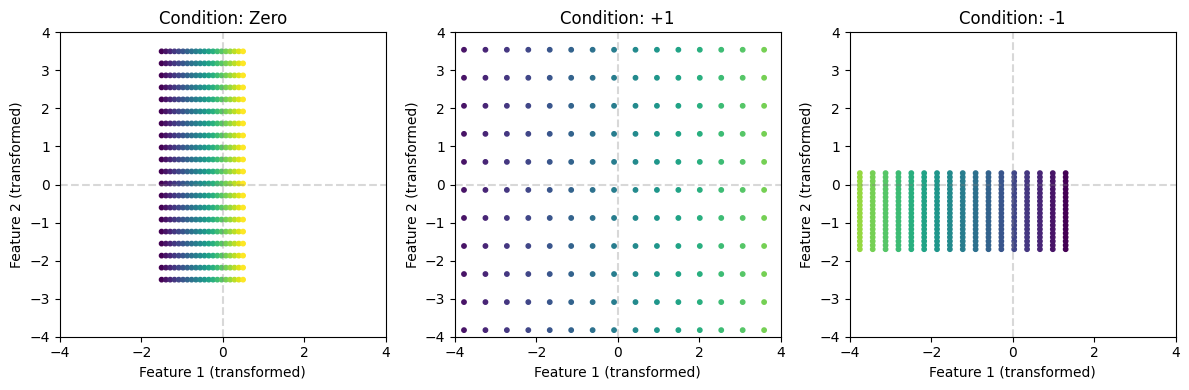

Notice how the same input grid is scaled and shifted differently based on the condition!


In [6]:
# Create a trained-like FiLM layer with non-trivial weights
film_demo = FiLMLayer(d_feature=2, d_condition=4)

# Manually set weights to show clear modulation
with torch.no_grad():
    film_demo.gamma_net.weight.fill_(0.5)
    film_demo.gamma_net.bias = nn.Parameter(torch.tensor([0.5, 1.5]))
    film_demo.beta_net.weight.fill_(0.3)
    film_demo.beta_net.bias = nn.Parameter(torch.tensor([-0.5, 0.5]))

# Generate input grid
x_range = torch.linspace(-2, 2, 20)
y_range = torch.linspace(-2, 2, 20)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
inputs = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Apply FiLM with different conditions
conditions = [
    torch.zeros(400, 4),
    torch.ones(400, 4),
    -torch.ones(400, 4),
]
titles = ['Condition: Zero', 'Condition: +1', 'Condition: -1']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, cond, title in zip(axes, conditions, titles):
    out = film_demo(inputs, cond).detach()
    ax.scatter(out[:, 0], out[:, 1], c=inputs[:, 0], cmap='viridis', s=10)
    ax.set_xlabel('Feature 1 (transformed)')
    ax.set_ylabel('Feature 2 (transformed)')
    ax.set_title(title)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
print("Notice how the same input grid is scaled and shifted differently based on the condition!")

## Component 3: Full Temporal Model

The complete model stacks multiple FiLM-modulated MLP blocks:

```
Input → [FiLM → Linear → Norm → ReLU] × N → Output
           ↑
    Time Encoding
```

Each layer receives the same temporal encoding, allowing time-aware processing throughout.

In [7]:
from models import TemporalTabularModel

# Create the full model
model = TemporalTabularModel(
    d_in=10,          # 10 input features
    d_out=1,          # 1 output (regression)
    d_time=16,        # Temporal encoding dimension
    n_blocks=3,       # 3 MLP blocks
    d_block=64,       # Hidden dimension
    dropout=0.1,
)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {model.count_parameters():,}")

Model Architecture:
TemporalTabularModel(
  (time_encoder): TemporalEncoder(
    (positional): PositionalEncoding()
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (input_film): FiLMLayer(
    (gamma_net): Linear(in_features=16, out_features=10, bias=True)
    (beta_net): Linear(in_features=16, out_features=10, bias=True)
  )
  (blocks): ModuleList(
    (0): TemporalMLPBlock(
      (linear): Linear(in_features=10, out_features=64, bias=True)
      (film): FiLMLayer(
        (gamma_net): Linear(in_features=16, out_features=64, bias=True)
        (beta_net): Linear(in_features=16, out_features=64, bias=True)
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): ReLU()
    )
    (1-2): 2 x TemporalMLPBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
  

In [8]:
# Forward pass example
batch_size = 4
x = torch.randn(batch_size, 10)  # Features
time_idx = torch.tensor([0, 10, 20, 30])  # Different time periods

# Predict
output = model(x, time_idx)

print(f"Input shape: {x.shape}")
print(f"Time indices: {time_idx.numpy()}")
print(f"Output shape: {output.shape}")
print(f"\nPredictions: {output.detach().numpy().flatten().round(3)}")

Input shape: torch.Size([4, 10])
Time indices: [ 0 10 20 30]
Output shape: torch.Size([4, 1])

Predictions: [-0.559 -0.913 -1.103 -0.58 ]


## Experiment: Learning with Temporal Drift

Let's create a dataset where the relationship between X and Y changes over time, and see how the temporal model adapts.

X shape: torch.Size([2000, 5])
y shape: torch.Size([2000, 1])
Time periods: [0 1 2 3 4]


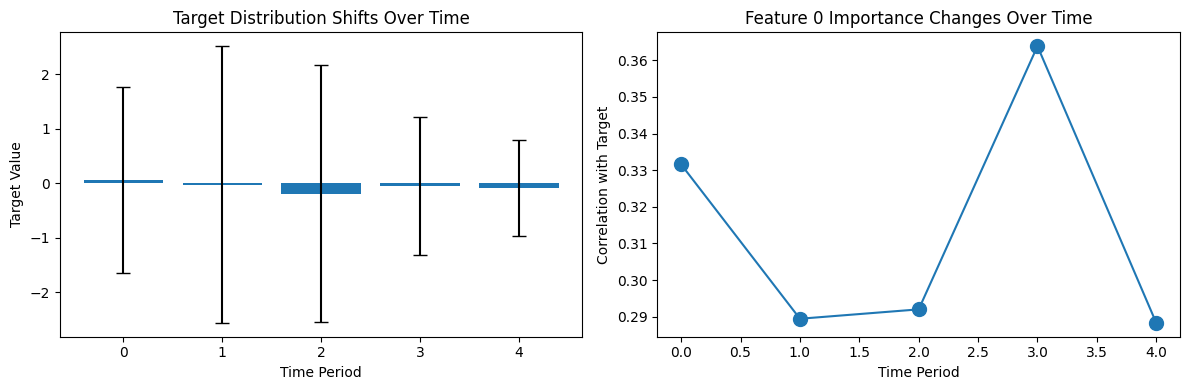

In [9]:
def generate_drifting_data(n_samples=1000, n_features=5, n_periods=5):
    """
    Generate data where y = X @ coef(t) + noise
    and coef(t) changes over time periods.
    """
    samples_per_period = n_samples // n_periods
    
    X_all, y_all, t_all = [], [], []
    
    # Base coefficients
    base_coef = np.random.randn(n_features)
    
    for t in range(n_periods):
        X = np.random.randn(samples_per_period, n_features)
        
        # Coefficients drift with time
        drift = np.sin(2 * np.pi * t / n_periods) * 0.5
        coef = base_coef * (1 + drift)  # Scale changes over time
        
        y = X @ coef + 0.1 * np.random.randn(samples_per_period)
        
        X_all.append(X)
        y_all.append(y)
        t_all.append(np.full(samples_per_period, t))
    
    return (
        torch.FloatTensor(np.vstack(X_all)),
        torch.FloatTensor(np.concatenate(y_all)).unsqueeze(1),
        torch.LongTensor(np.concatenate(t_all)),
    )

# Generate data
X, y, time_idx = generate_drifting_data(n_samples=2000, n_features=5, n_periods=5)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Time periods: {torch.unique(time_idx).numpy()}")

# Visualize the drift
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Mean target per period
means = [y[time_idx == t].mean().item() for t in range(5)]
stds = [y[time_idx == t].std().item() for t in range(5)]

axes[0].bar(range(5), means, yerr=stds, capsize=5)
axes[0].set_xlabel('Time Period')
axes[0].set_ylabel('Target Value')
axes[0].set_title('Target Distribution Shifts Over Time')

# Correlation between feature 0 and target per period
corrs = [np.corrcoef(X[time_idx == t, 0].numpy(), y[time_idx == t].squeeze().numpy())[0, 1] 
         for t in range(5)]
axes[1].plot(range(5), corrs, 'o-', markersize=10)
axes[1].set_xlabel('Time Period')
axes[1].set_ylabel('Correlation with Target')
axes[1].set_title('Feature 0 Importance Changes Over Time')

plt.tight_layout()
plt.show()

### Visualizing the True Concept Drift

Let's create detailed visualizations showing exactly how the feature-target relationships change across time periods. This is the **ground truth** that our temporal model needs to learn.

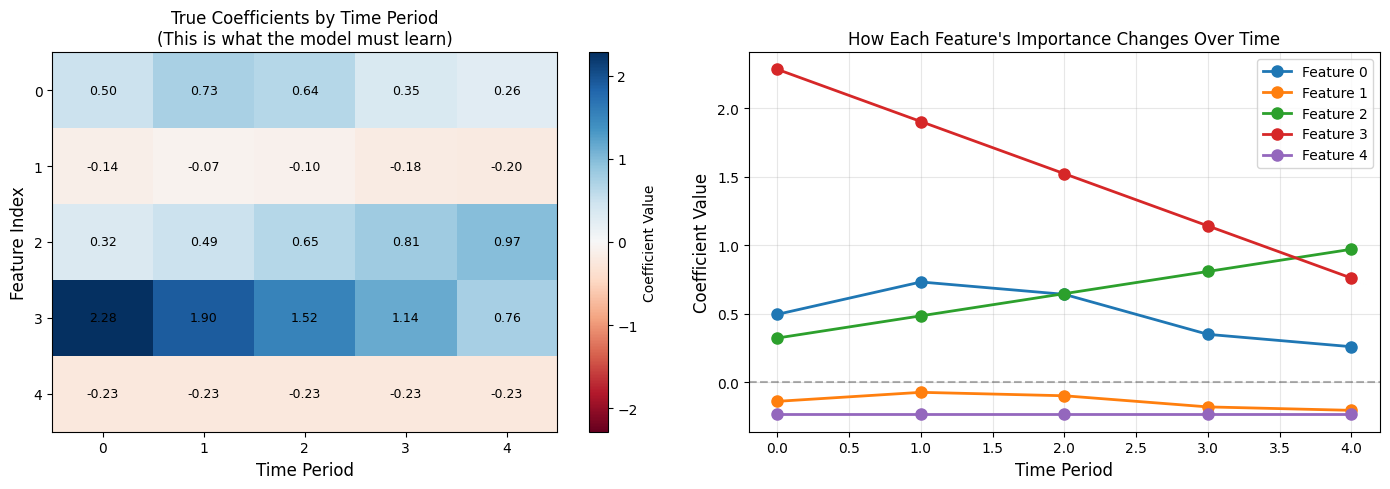

Feature-specific drift patterns:
  - Feature 0: Sinusoidal (peaks at t=1)
  - Feature 1: Inverse sinusoidal (peaks at t=3)
  - Feature 2: Linear increase (0.5× → 1.5×)
  - Feature 3: Linear decrease (1.5× → 0.5×)
  - Feature 4: Constant (no drift)


In [20]:
# Regenerate data with FEATURE-SPECIFIC drift patterns
# Each feature drifts differently over time (more realistic concept drift)
np.random.seed(42)
n_samples, n_features, n_periods = 2000, 5, 5
samples_per_period = n_samples // n_periods

# Store the true coefficients for each time period
base_coef = np.random.randn(n_features)

# Different drift patterns per feature:
# Feature 0: sinusoidal (peaks at t=1)
# Feature 1: inverse sinusoidal (peaks at t=3)  
# Feature 2: linear increase
# Feature 3: linear decrease
# Feature 4: constant (no drift)
def get_feature_drift(t, feat_idx, n_periods):
    """Get drift multiplier for each feature at time t."""
    if feat_idx == 0:
        return 1 + 0.5 * np.sin(2 * np.pi * t / n_periods)  # Sinusoidal
    elif feat_idx == 1:
        return 1 - 0.5 * np.sin(2 * np.pi * t / n_periods)  # Inverse sinusoidal
    elif feat_idx == 2:
        return 0.5 + t / (n_periods - 1)  # Linear increase: 0.5 → 1.5
    elif feat_idx == 3:
        return 1.5 - t / (n_periods - 1)  # Linear decrease: 1.5 → 0.5
    else:
        return 1.0  # No drift

true_coefs = []
X_all, y_all, t_all = [], [], []

for t in range(n_periods):
    X = np.random.randn(samples_per_period, n_features)
    
    # Apply feature-specific drift
    coef = np.array([
        base_coef[i] * get_feature_drift(t, i, n_periods) 
        for i in range(n_features)
    ])
    true_coefs.append(coef)
    
    y = X @ coef + 0.1 * np.random.randn(samples_per_period)
    
    X_all.append(X)
    y_all.append(y)
    t_all.append(np.full(samples_per_period, t))

X = torch.FloatTensor(np.vstack(X_all))
y = torch.FloatTensor(np.concatenate(y_all)).unsqueeze(1)
time_idx = torch.LongTensor(np.concatenate(t_all))
true_coefs = np.array(true_coefs)

# =============================================================================
# PLOT 1: True Coefficients Over Time
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of coefficients
im = axes[0].imshow(true_coefs.T, aspect='auto', cmap='RdBu', 
                     vmin=-np.abs(true_coefs).max(), vmax=np.abs(true_coefs).max())
axes[0].set_xlabel('Time Period', fontsize=12)
axes[0].set_ylabel('Feature Index', fontsize=12)
axes[0].set_title('True Coefficients by Time Period\n(This is what the model must learn)', fontsize=12)
axes[0].set_xticks(range(n_periods))
axes[0].set_yticks(range(n_features))
plt.colorbar(im, ax=axes[0], label='Coefficient Value')

# Add coefficient values as text
for i in range(n_features):
    for j in range(n_periods):
        axes[0].text(j, i, f'{true_coefs[j, i]:.2f}', ha='center', va='center', fontsize=9)

# Line plot of coefficients over time
for i in range(n_features):
    axes[1].plot(range(n_periods), true_coefs[:, i], 'o-', label=f'Feature {i}', linewidth=2, markersize=8)
axes[1].set_xlabel('Time Period', fontsize=12)
axes[1].set_ylabel('Coefficient Value', fontsize=12)
axes[1].set_title('How Each Feature\'s Importance Changes Over Time', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("Feature-specific drift patterns:")
print("  - Feature 0: Sinusoidal (peaks at t=1)")
print("  - Feature 1: Inverse sinusoidal (peaks at t=3)")
print("  - Feature 2: Linear increase (0.5× → 1.5×)")
print("  - Feature 3: Linear decrease (1.5× → 0.5×)")
print("  - Feature 4: Constant (no drift)")

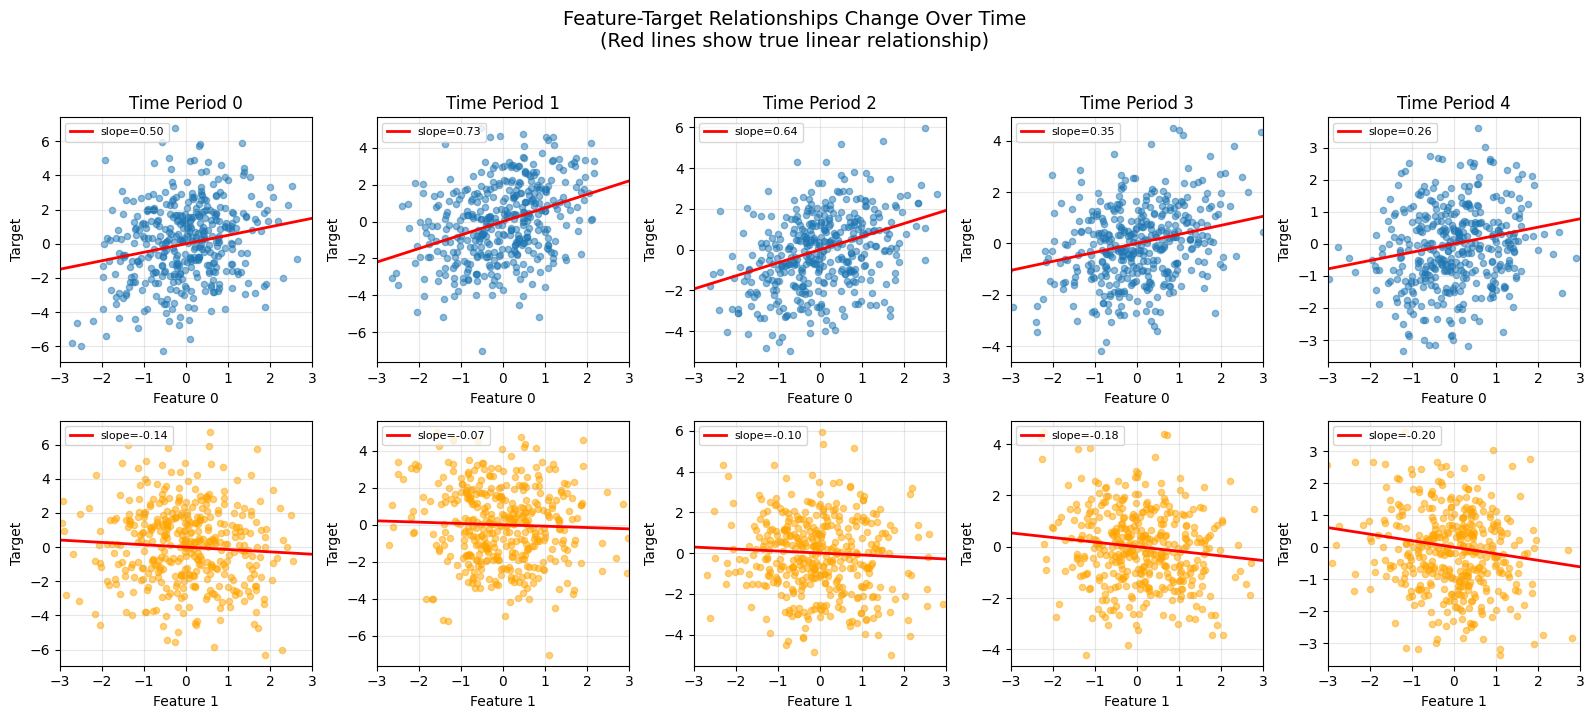

Notice how the SLOPE of the relationship changes across time periods!
This is concept drift - the same feature has different predictive power at different times.


In [21]:
# =============================================================================
# PLOT 2: Feature vs Target Scatter Plots Per Time Period
# =============================================================================
fig, axes = plt.subplots(2, 5, figsize=(16, 7))

# Top row: Feature 0 vs Target for each time period
for t in range(n_periods):
    ax = axes[0, t]
    mask = time_idx == t
    x_feat = X[mask, 0].numpy()
    y_target = y[mask].squeeze().numpy()
    
    ax.scatter(x_feat, y_target, alpha=0.5, s=20)
    
    # Add regression line
    slope = true_coefs[t, 0]
    x_line = np.linspace(-3, 3, 100)
    y_line = slope * x_line
    ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'slope={slope:.2f}')
    
    ax.set_xlabel('Feature 0')
    ax.set_ylabel('Target')
    ax.set_title(f'Time Period {t}')
    ax.set_xlim(-3, 3)
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

# Bottom row: Feature 1 vs Target for each time period
for t in range(n_periods):
    ax = axes[1, t]
    mask = time_idx == t
    x_feat = X[mask, 1].numpy()
    y_target = y[mask].squeeze().numpy()
    
    ax.scatter(x_feat, y_target, alpha=0.5, s=20, color='orange')
    
    # Add regression line
    slope = true_coefs[t, 1]
    x_line = np.linspace(-3, 3, 100)
    y_line = slope * x_line
    ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'slope={slope:.2f}')
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Target')
    ax.set_xlim(-3, 3)
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Feature-Target Relationships Change Over Time\n(Red lines show true linear relationship)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Notice how the SLOPE of the relationship changes across time periods!")
print("This is concept drift - the same feature has different predictive power at different times.")

In [22]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Split data
n_train = 1600
X_train, y_train, t_train = X[:n_train], y[:n_train], time_idx[:n_train]
X_test, y_test, t_test = X[n_train:], y[n_train:], time_idx[n_train:]

train_loader = DataLoader(
    TensorDataset(X_train, y_train, t_train),
    batch_size=64, shuffle=True
)

# Create models
temporal_model = TemporalTabularModel(d_in=5, d_out=1, d_time=16, n_blocks=2, d_block=32)

# Simple MLP baseline (no temporal awareness)
from models.base import MLP
baseline_model = MLP(d_in=5, d_out=1, n_blocks=2, d_block=32)

print(f"Temporal model params: {temporal_model.count_parameters():,}")
print(f"Baseline model params: {baseline_model.count_parameters():,}")

Temporal model params: 5,339
Baseline model params: 1,409


Training temporal model...
Training baseline MLP...


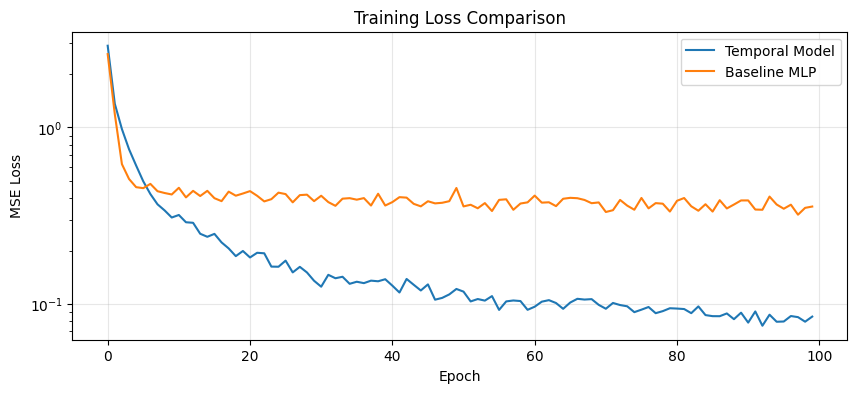

In [23]:
def train_model(model, train_loader, n_epochs=100, use_time=True):
    """Train a model and return loss history."""
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    losses = []
    
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch, t_batch in train_loader:
            optimizer.zero_grad()
            
            if use_time and hasattr(model, 'time_encoder'):
                pred = model(X_batch, t_batch)
            else:
                pred = model(X_batch)
            
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        losses.append(epoch_loss / len(train_loader))
    
    return losses

# Train both models
print("Training temporal model...")
temporal_losses = train_model(temporal_model, train_loader, n_epochs=100, use_time=True)

print("Training baseline MLP...")
baseline_losses = train_model(baseline_model, train_loader, n_epochs=100, use_time=False)

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(temporal_losses, label='Temporal Model')
plt.plot(baseline_losses, label='Baseline MLP')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

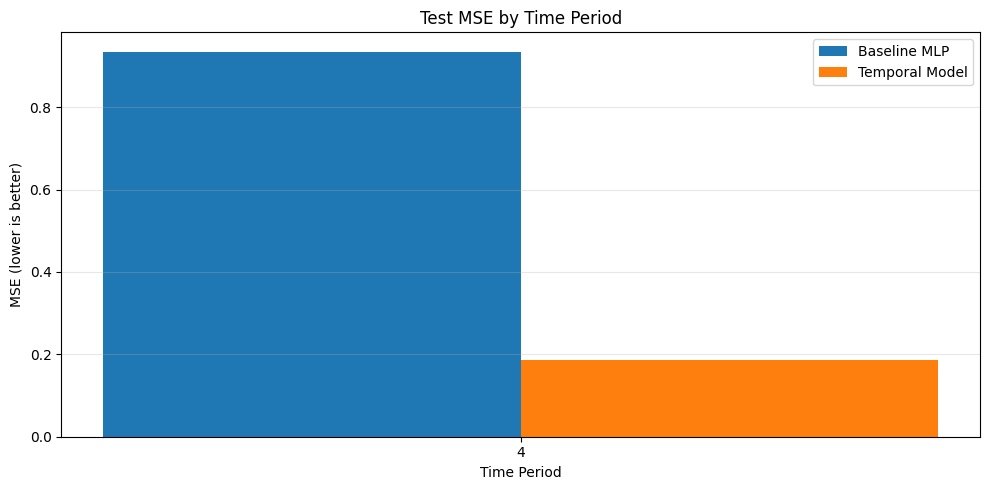


Test MSE Summary:
Period     Baseline     Temporal     Improvement 
----------------------------------------------
4          0.9348       0.1855       +80.2%
----------------------------------------------
Average    0.9348       0.1855       +80.2%


In [24]:
# Evaluate per time period
@torch.no_grad()
def evaluate_per_period(model, X, y, time_idx, use_time=True):
    model.eval()
    results = {}
    
    for t in torch.unique(time_idx):
        mask = time_idx == t
        X_t, y_t, t_t = X[mask], y[mask], time_idx[mask]
        
        if use_time and hasattr(model, 'time_encoder'):
            pred = model(X_t, t_t)
        else:
            pred = model(X_t)
        
        mse = ((pred - y_t) ** 2).mean().item()
        results[t.item()] = mse
    
    return results

temporal_results = evaluate_per_period(temporal_model, X_test, y_test, t_test, use_time=True)
baseline_results = evaluate_per_period(baseline_model, X_test, y_test, t_test, use_time=False)

# Plot comparison
periods = list(temporal_results.keys())
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(periods))

bars1 = ax.bar(x - width/2, [baseline_results[p] for p in periods], width, label='Baseline MLP')
bars2 = ax.bar(x + width/2, [temporal_results[p] for p in periods], width, label='Temporal Model')

ax.set_xlabel('Time Period')
ax.set_ylabel('MSE (lower is better)')
ax.set_title('Test MSE by Time Period')
ax.set_xticks(x)
ax.set_xticklabels(periods)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary
print("\nTest MSE Summary:")
print(f"{'Period':<10} {'Baseline':<12} {'Temporal':<12} {'Improvement':<12}")
print("-" * 46)
for p in periods:
    improvement = (baseline_results[p] - temporal_results[p]) / baseline_results[p] * 100
    print(f"{p:<10} {baseline_results[p]:<12.4f} {temporal_results[p]:<12.4f} {improvement:+.1f}%")

avg_baseline = np.mean(list(baseline_results.values()))
avg_temporal = np.mean(list(temporal_results.values()))
print("-" * 46)
print(f"{'Average':<10} {avg_baseline:<12.4f} {avg_temporal:<12.4f} {(avg_baseline-avg_temporal)/avg_baseline*100:+.1f}%")

## Inspecting Learned Temporal Encodings

Let's look at what the model learned about different time periods.

Learned temporal encodings:
Shape: torch.Size([5, 16])


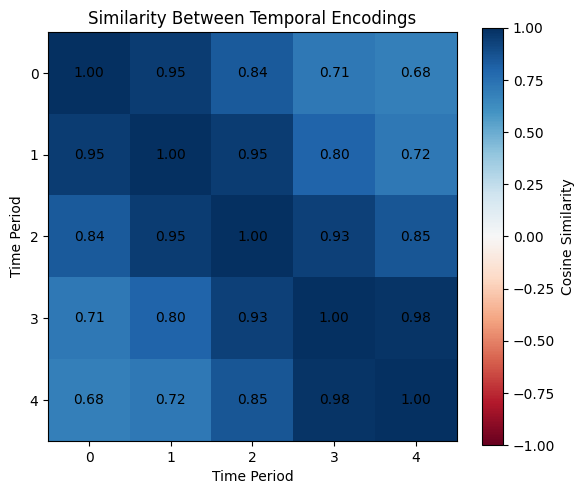

In [25]:
# Extract temporal encodings for each period
temporal_model.eval()
with torch.no_grad():
    time_indices = torch.arange(5)
    encodings = temporal_model.time_encoder(time_indices)

print("Learned temporal encodings:")
print(f"Shape: {encodings.shape}")

# Compute similarity between time periods
sim_matrix = torch.cosine_similarity(
    encodings.unsqueeze(0),
    encodings.unsqueeze(1),
    dim=-1
)

plt.figure(figsize=(6, 5))
plt.imshow(sim_matrix.numpy(), cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Time Period')
plt.ylabel('Time Period')
plt.title('Similarity Between Temporal Encodings')
plt.xticks(range(5))
plt.yticks(range(5))

for i in range(5):
    for j in range(5):
        plt.text(j, i, f'{sim_matrix[i,j]:.2f}', ha='center', va='center')

plt.tight_layout()
plt.show()

## Inspecting Learned Gamma and Beta

Now let's look at the actual γ (scale) and β (shift) values the model learned for each time period. This shows us **how the model modulates each input feature** based on time.

=== Learned Gamma (Scale) per Time Period ===
Shape: torch.Size([5, 5]) (time_periods × input_features)



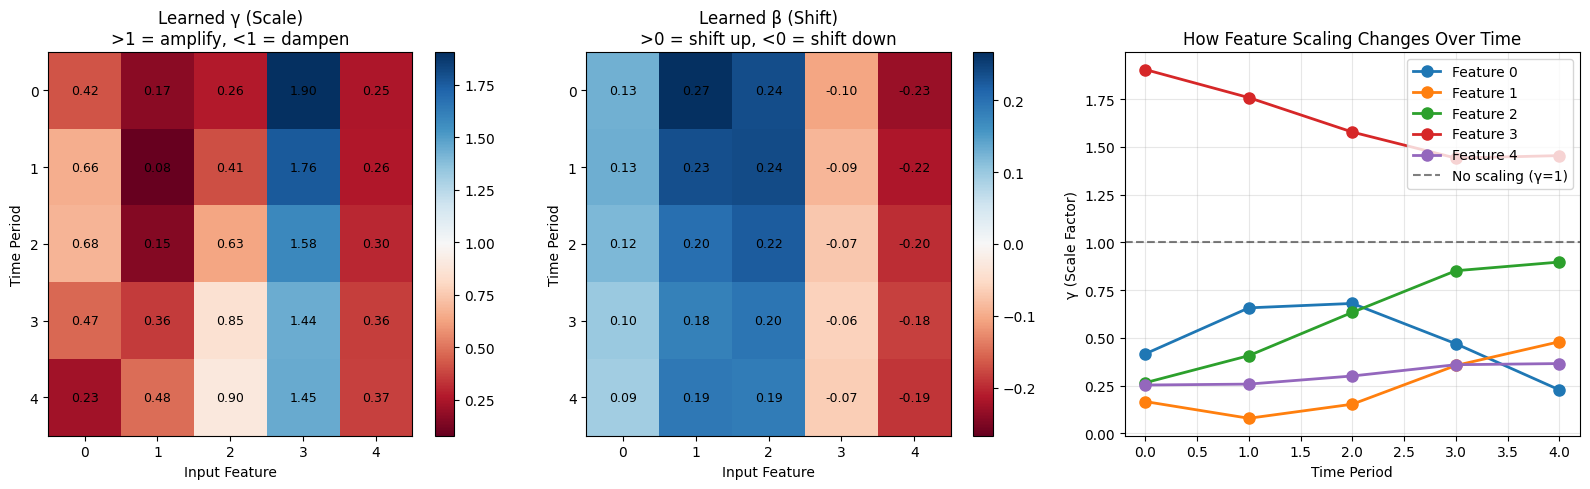


=== Interpretation ===
The model learned time-varying modulation:
  Time 0: Feature 3 amplified most (γ=1.90), Feature 1 dampened most (γ=0.17)
  Time 1: Feature 3 amplified most (γ=1.76), Feature 1 dampened most (γ=0.08)
  Time 2: Feature 3 amplified most (γ=1.58), Feature 1 dampened most (γ=0.15)
  Time 3: Feature 3 amplified most (γ=1.44), Feature 1 dampened most (γ=0.36)
  Time 4: Feature 3 amplified most (γ=1.45), Feature 0 dampened most (γ=0.23)


In [28]:
# Extract gamma and beta from the input FiLM layer for each time period
temporal_model.eval()

with torch.no_grad():
    time_indices = torch.arange(5)
    time_enc = temporal_model.time_encoder(time_indices)  # (5, d_time)
    
    # Get gamma and beta from the input_film layer
    gamma = temporal_model.input_film.gamma_net(time_enc)  # (5, 5) - 5 time periods, 5 input features
    beta = temporal_model.input_film.beta_net(time_enc)    # (5, 5)

print("=== Learned Gamma (Scale) per Time Period ===")
print(f"Shape: {gamma.shape} (time_periods × input_features)\n")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Gamma heatmap
im1 = axes[0].imshow(gamma.numpy(), aspect='auto', cmap='RdBu', 
                      vmin=gamma.min().item(), vmax=gamma.max().item())
axes[0].set_xlabel('Input Feature')
axes[0].set_ylabel('Time Period')
axes[0].set_title('Learned γ (Scale)\n>1 = amplify, <1 = dampen')
axes[0].set_xticks(range(5))
axes[0].set_yticks(range(5))
plt.colorbar(im1, ax=axes[0])

for i in range(5):
    for j in range(5):
        axes[0].text(j, i, f'{gamma[i,j]:.2f}', ha='center', va='center', fontsize=9)

# Plot 2: Beta heatmap
im2 = axes[1].imshow(beta.numpy(), aspect='auto', cmap='RdBu',
                      vmin=-max(abs(beta.min().item()), abs(beta.max().item())),
                      vmax=max(abs(beta.min().item()), abs(beta.max().item())))
axes[1].set_xlabel('Input Feature')
axes[1].set_ylabel('Time Period')
axes[1].set_title('Learned β (Shift)\n>0 = shift up, <0 = shift down')
axes[1].set_xticks(range(5))
axes[1].set_yticks(range(5))
plt.colorbar(im2, ax=axes[1])

for i in range(5):
    for j in range(5):
        axes[1].text(j, i, f'{beta[i,j]:.2f}', ha='center', va='center', fontsize=9)

# Plot 3: Gamma over time for each feature
for feat in range(5):
    axes[2].plot(range(5), gamma[:, feat].numpy(), 'o-', label=f'Feature {feat}', linewidth=2, markersize=8)
axes[2].axhline(1.0, color='black', linestyle='--', alpha=0.5, label='No scaling (γ=1)')
axes[2].set_xlabel('Time Period')
axes[2].set_ylabel('γ (Scale Factor)')
axes[2].set_title('How Feature Scaling Changes Over Time')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print interpretation
print("\n=== Interpretation ===")
print("The model learned time-varying modulation:")
for t in range(5):
    max_gamma_feat = gamma[t].argmax().item()
    min_gamma_feat = gamma[t].argmin().item()
    print(f"  Time {t}: Feature {max_gamma_feat} amplified most (γ={gamma[t, max_gamma_feat]:.2f}), "
          f"Feature {min_gamma_feat} dampened most (γ={gamma[t, min_gamma_feat]:.2f})")

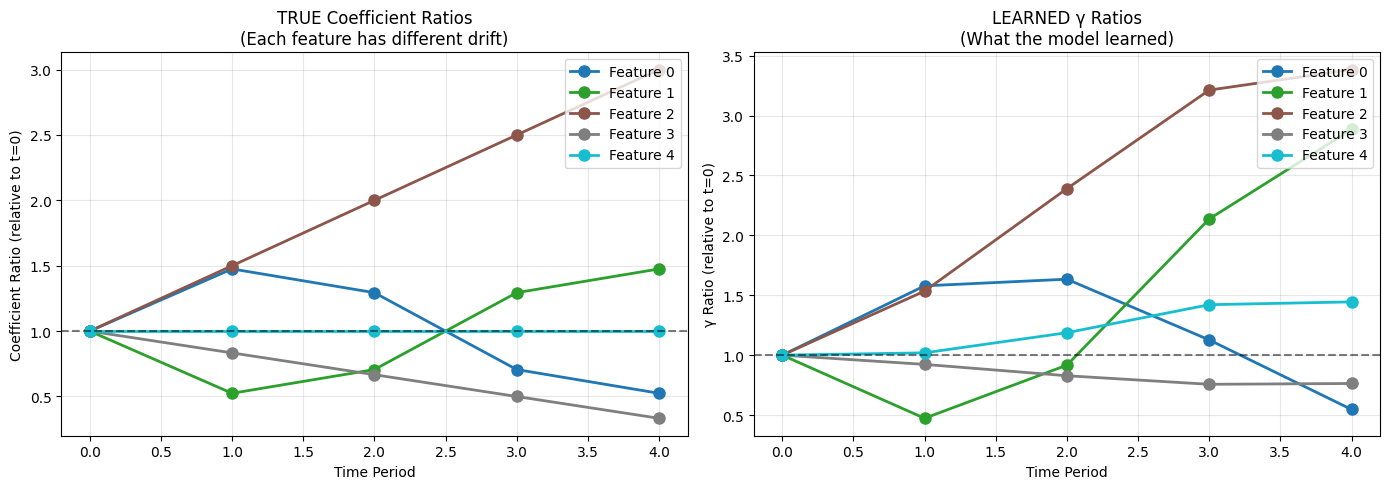

Expected patterns in TRUE coefficients (left plot):
  - Feature 0 (blue): Sinusoidal - up at t=1, down at t=3
  - Feature 1 (orange): Inverse - down at t=1, up at t=3
  - Feature 2 (green): Linear increase
  - Feature 3 (red): Linear decrease
  - Feature 4 (purple): Constant at 1.0

If the model learned correctly, the right plot should show similar patterns.


In [29]:
# Compare learned gamma to true coefficient changes
# Now each feature has a DIFFERENT drift pattern - does gamma learn this?

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Normalize both for comparison (relative to t=0)
true_coef_normalized = true_coefs / true_coefs[0]  # Relative to t=0
gamma_normalized = gamma.numpy() / gamma[0].numpy()  # Relative to t=0

# Plot true coefficient ratios (should show 5 DIFFERENT patterns now)
colors = plt.cm.tab10(np.linspace(0, 1, 5))
for feat in range(5):
    axes[0].plot(range(5), true_coef_normalized[:, feat], 'o-', 
                 label=f'Feature {feat}', linewidth=2, markersize=8, color=colors[feat])
axes[0].axhline(1.0, color='black', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Time Period')
axes[0].set_ylabel('Coefficient Ratio (relative to t=0)')
axes[0].set_title('TRUE Coefficient Ratios\n(Each feature has different drift)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Plot learned gamma ratios
for feat in range(5):
    axes[1].plot(range(5), gamma_normalized[:, feat], 'o-', 
                 label=f'Feature {feat}', linewidth=2, markersize=8, color=colors[feat])
axes[1].axhline(1.0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Time Period')
axes[1].set_ylabel('γ Ratio (relative to t=0)')
axes[1].set_title('LEARNED γ Ratios\n(What the model learned)')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Expected patterns in TRUE coefficients (left plot):")
print("  - Feature 0 (blue): Sinusoidal - up at t=1, down at t=3")
print("  - Feature 1 (orange): Inverse - down at t=1, up at t=3")
print("  - Feature 2 (green): Linear increase")
print("  - Feature 3 (red): Linear decrease")
print("  - Feature 4 (purple): Constant at 1.0")
print()
print("If the model learned correctly, the right plot should show similar patterns.")

## Key Takeaways

1. **FiLM modulation** allows networks to adapt their behavior based on temporal context

2. **Temporal encoding** converts time indices into rich representations that capture:
   - Periodic patterns (via sinusoidal encoding)
   - Complex temporal relationships (via learned MLP)

3. **Identity initialization** ensures the model starts as a standard MLP and gradually learns temporal adaptations

4. The model learns **time-specific transformations** while sharing most parameters, enabling:
   - Efficient parameter usage
   - Transfer between time periods
   - Graceful handling of unseen time periods

## When to Use Temporal Modulation

✅ **Good for:**
- Data with known temporal structure
- Concept drift scenarios
- Seasonal/cyclical patterns

❌ **Not needed for:**
- Static datasets
- When time isn't available
- Very small datasets (may overfit)